In [31]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
base_dir = '/home/tun62034/fuadhassan/nfl-data-bowl/'
data_dir = os.path.join(base_dir, 'Sample_Data/Processed')
sys.path.append(base_dir)
sys.path.append(data_dir)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [35]:
def load_data(data_dir):
    vls = pd.read_csv(os.path.join(data_dir, 'velocity_late_shifts.csv'))
    omp = pd.read_csv(os.path.join(data_dir, 'offensive_motion_plays.csv'))
    pts = pd.read_csv(os.path.join(data_dir, 'players_through_snap.csv'))
    nds = pd.read_csv(os.path.join(data_dir, 'nearest_defender_at_snap.csv'))
    target = pd.read_csv(os.path.join(data_dir, 'playlabels.csv'))
    
    return vls, omp,pts,nds, target

vls, omp, pts,nds, target = load_data(data_dir)
print(vls.shape, omp.shape, pts.shape, nds.shape, target.shape)
merged_df = omp.copy()
merged_df = merged_df.merge(target, on=['gameId', 'playId'], how='left')
merged_df = merged_df.merge(vls, on=['gameId', 'playId'], how='left')
merged_df = merged_df.merge(pts, on=['gameId', 'playId'], how='left')
merged_df = merged_df.merge(nds, on=['gameId', 'playId'], how='left')
merged_df = merged_df.fillna(0)
df = merged_df.copy()
df_data = df.drop(['gameId', 'playId'], axis=1)

(12814, 5) (16124, 10) (3850, 6) (16124, 7) (15740, 3)


In [36]:
X = df.drop(['gameId','playId','isConfused'], axis=1)
y = df['isConfused']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12899, 20), (3225, 20), (12899,), (3225,))

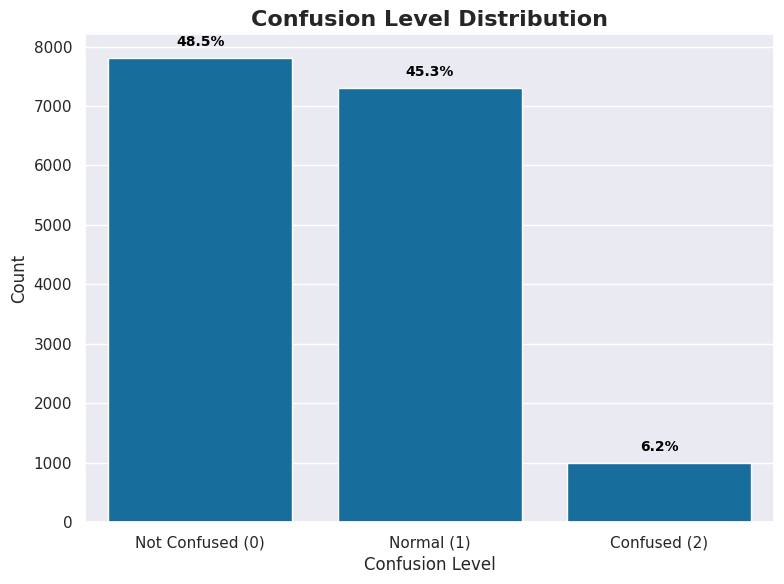

In [38]:
# Set visual theme
sns.set_theme( palette="colorblind")

# Initialize the figure
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='isConfused', data=df, order=sorted(df['isConfused'].unique()))

# Title and axis labels
plt.title('Confusion Level Distribution', fontsize=16, weight='bold')
plt.xlabel('Confusion Level', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Customize x-tick labels
labels = ['Not Confused (0)', 'Normal (1)', 'Confused (2)']
ax.set_xticklabels(labels)

# Add percentages on top of bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom',
                fontsize=10, color='black', weight='bold', 
                xytext=(0, 6), textcoords='offset points')

# Improve layout
plt.tight_layout()
plt.show()

# Radmon Forest

In [6]:
# Create the Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    max_depth=5,         # Limit tree depth
    random_state=42
)

# Fit on training data
rf_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, random_state=42)

In [7]:
# Make predictions
y_pred_rf = rf_clf.predict(X_test)

Random Forest Accuracy: 0.49

Confusion Matrix:
 [[1237  353    0]
 [1111  337    0]
 [ 139   48    0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.78      0.61      1590
         1.0       0.46      0.23      0.31      1448
         2.0       0.00      0.00      0.00       187

    accuracy                           0.49      3225
   macro avg       0.32      0.34      0.31      3225
weighted avg       0.45      0.49      0.44      3225



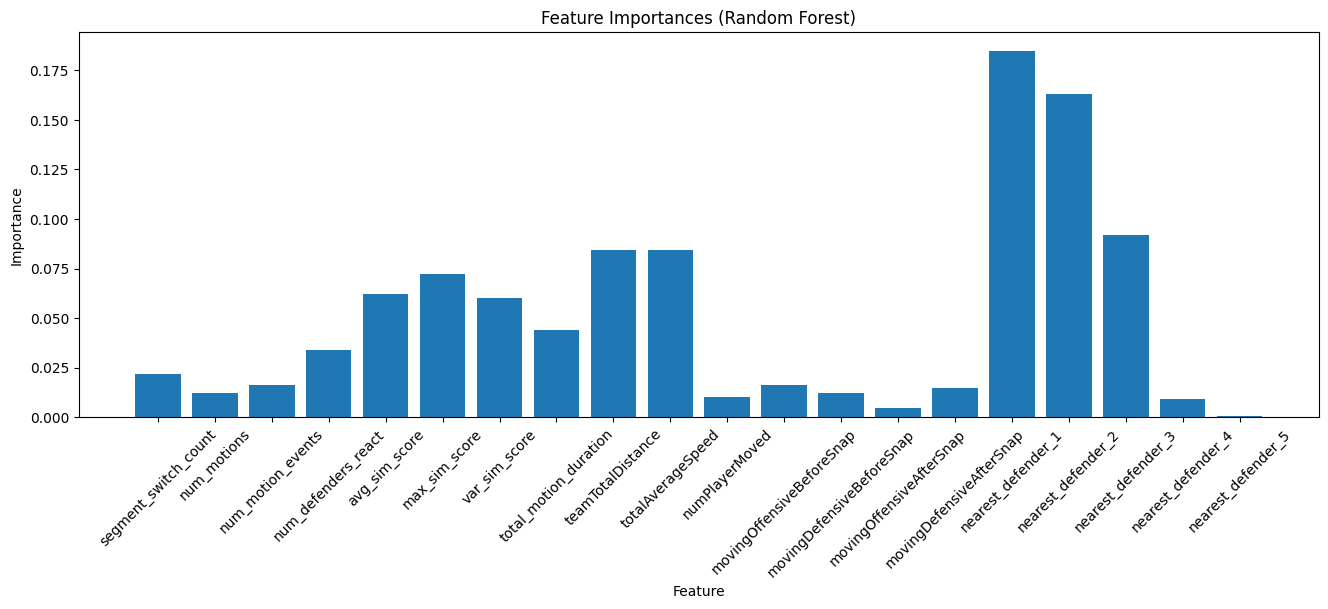

In [8]:
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Feature importance
importances = rf_clf.feature_importances_
features = X.columns  # Assuming X is a pandas DataFrame
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 5))
plt.bar(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45)  # Rotate feature labels by 45 degrees
plt.show()


In [10]:
# Drop 'gameId' and 'playId'
df_cleaned = df.drop(['gameId', 'playId'], axis=1)

# Define features and target
X = df_cleaned.drop('isConfused', axis=1)
y = df_cleaned['isConfused']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create Pipeline (StandardScaler + RandomForest)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Hyperparameter grid
param_grid = {
    'rf__n_estimators': [100, 200,500, 1000],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters:\n{grid_search.best_params_}")

# Predictions
y_pred = best_model.predict(X_test)




Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.5s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.5s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.5s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.5s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.7s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   3.0s
[CV] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2,


Confusion Matrix:


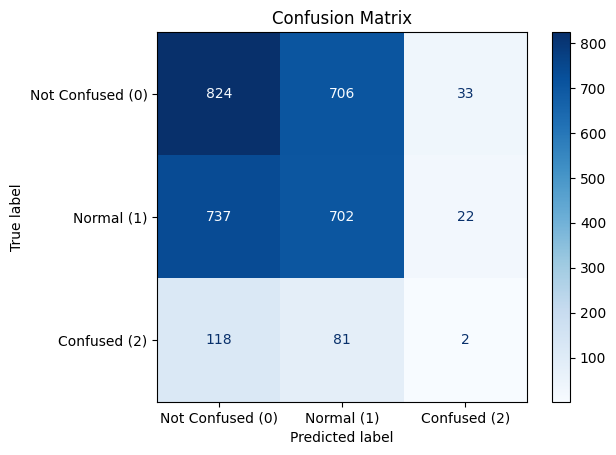


Classification Report:
                  precision    recall  f1-score   support

Not Confused (0)       0.49      0.53      0.51      1563
      Normal (1)       0.47      0.48      0.48      1461
    Confused (2)       0.04      0.01      0.02       201

        accuracy                           0.47      3225
       macro avg       0.33      0.34      0.33      3225
    weighted avg       0.45      0.47      0.46      3225



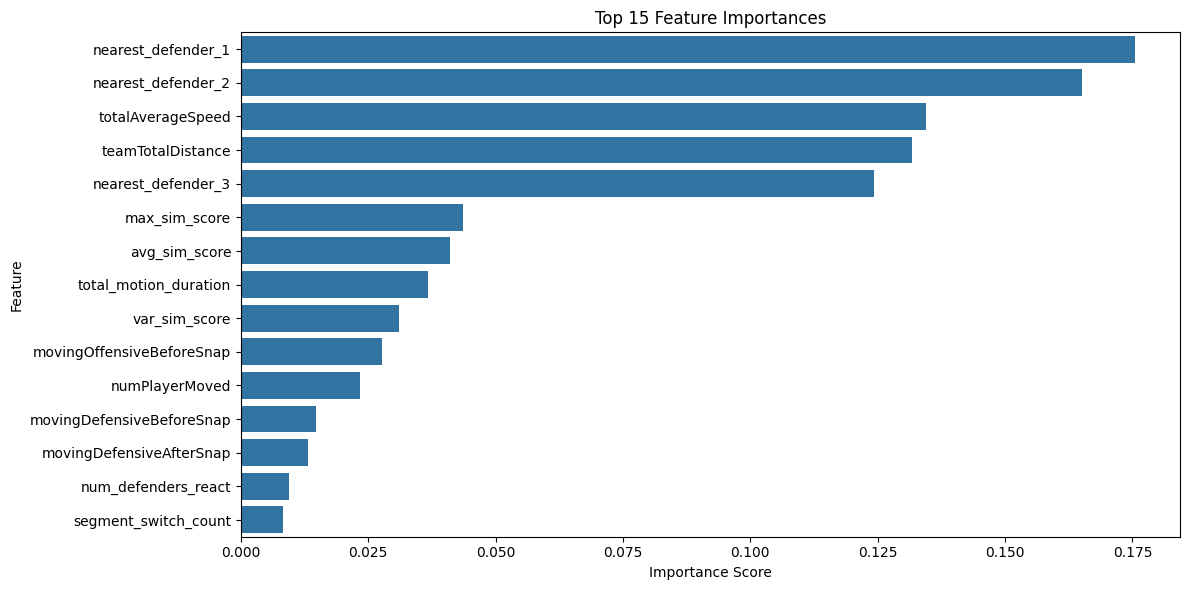

In [11]:
# Evaluation
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Confused (0)", "Normal (1)", "Confused (2)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Confused (0)", "Normal (1)", "Confused (2)"]))

# Plot Feature Importances
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

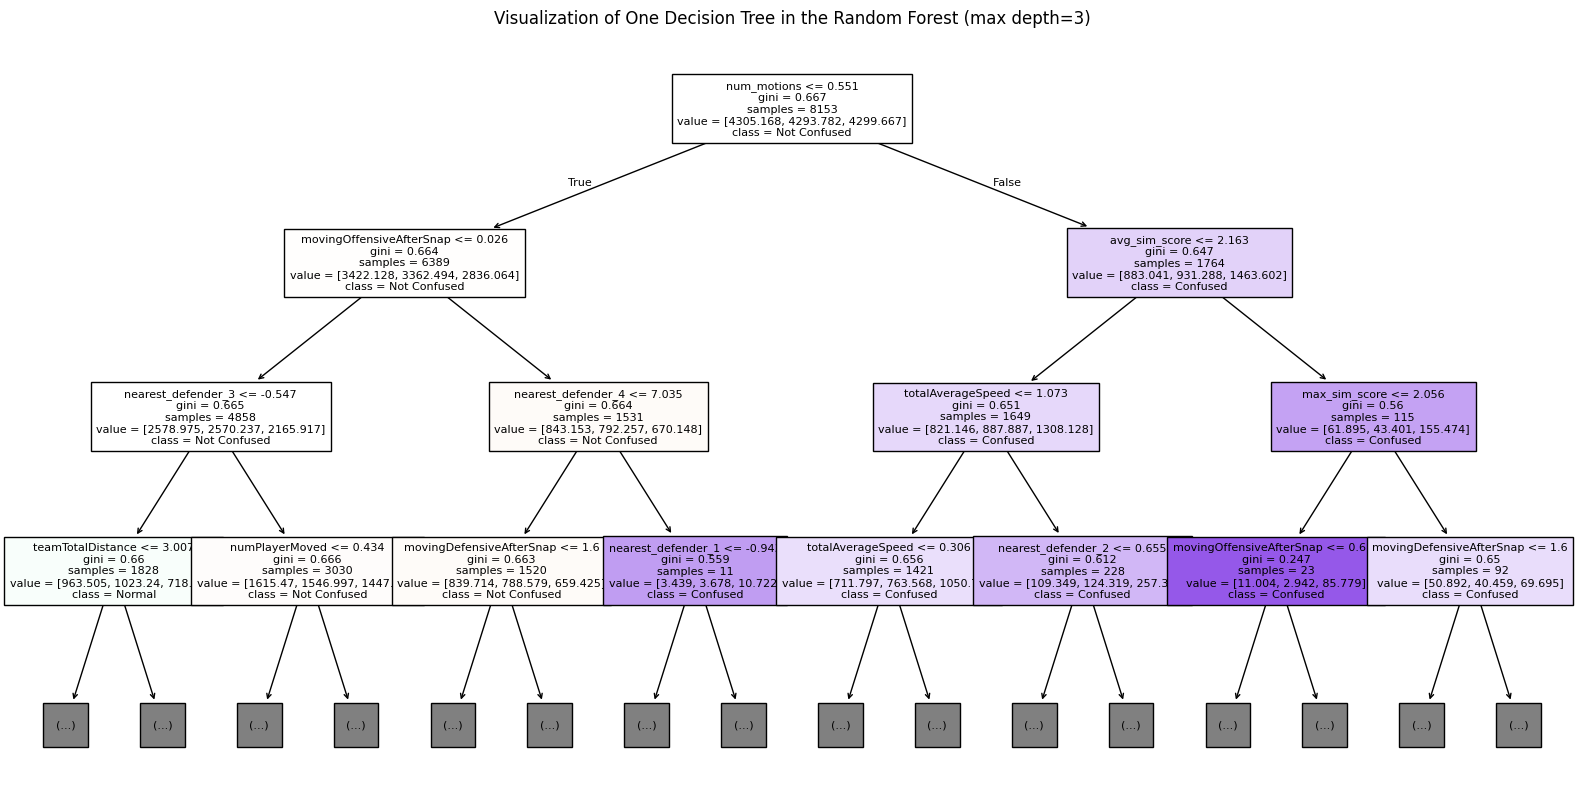

In [12]:
from sklearn.tree import plot_tree

# Extract one tree from the forest
estimator = best_model.named_steps['rf'].estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X.columns, class_names=["Not Confused", "Normal", "Confused"], filled=True, max_depth=3, fontsize=8)
plt.title("Visualization of One Decision Tree in the Random Forest (max depth=3)")
plt.show()


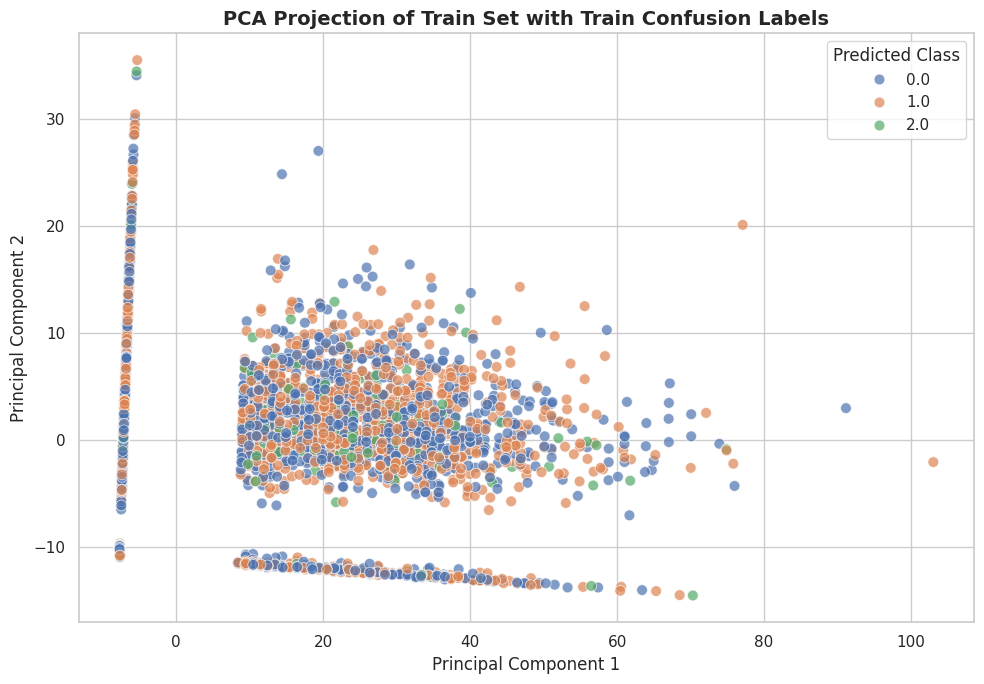

In [27]:
from sklearn.decomposition import PCA

# Assuming X_test and y_pred are already defined in the user's environment

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_train)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
pca_df["Predicted Confusion"] = y_train

# Plotting
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Predicted Confusion", palette="deep", alpha=0.7, s=60)

plt.title("PCA Projection of Train Set with Train Confusion Labels", fontsize=14, weight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Class", loc='best')
plt.tight_layout()
plt.show()


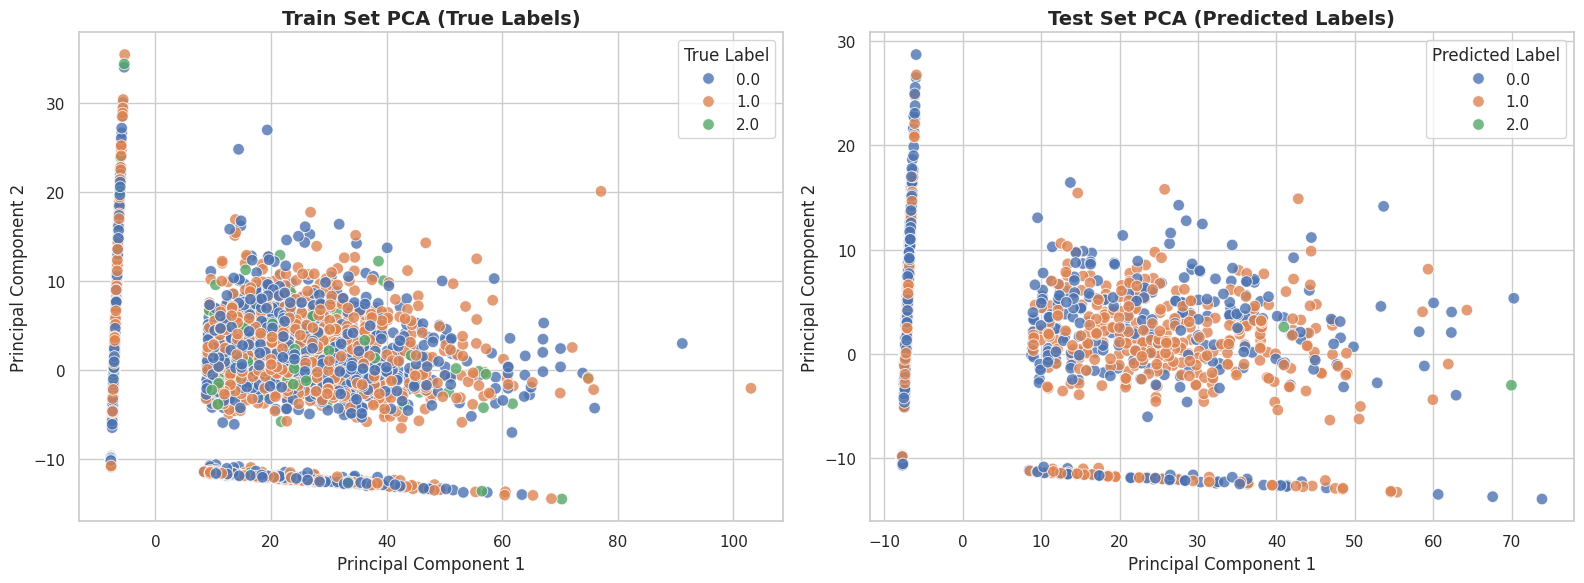

In [ ]:
# Perform PCA separately on train and test sets
pca_train = PCA(n_components=2)
X_train_pca = pca_train.fit_transform(X_train)

pca_test = PCA(n_components=2)
X_test_pca = pca_test.fit_transform(X_test)

# Create DataFrames for plotting
train_df = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
train_df["True Label"] = y_train

test_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
test_df["Predicted Label"] = y_pred

# Plotting both separately
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid", palette="colorblind")

# Train set PCA
sns.scatterplot(data=train_df, x="PC1", y="PC2", hue="True Label", ax=axes[0], palette="deep", s=70, alpha=0.8)
axes[0].set_title("Train Set PCA (True Labels)", fontsize=14, weight='bold')
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")

# Test set PCA
sns.scatterplot(data=test_df, x="PC1", y="PC2", hue="Predicted Label", ax=axes[1], palette="deep", s=70, alpha=0.8)
axes[1].set_title("Test Set PCA (Predicted Labels)", fontsize=14, weight='bold')
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load your dataset
# df = pd.read_csv("your_data.csv")  # Uncomment this if you're reading from a CSV

# Drop unnecessary columns
df_cleaned = df.drop(['gameId', 'playId'], axis=1)

# Split features and target
X = df_cleaned.drop('isConfused', axis=1)
y = df_cleaned['isConfused']

# Define models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=1000, class_weight='balanced', random_state=42),
    "MLP": MLPClassifier(max_iter=500, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Results list
results = []

# Loop through all models
for name, model in models.items():
    print(f"Evaluating: {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
    results.append({
        "Model": name,
        "Mean F1 Weighted": scores.mean(),
        "Std F1 Weighted": scores.std()
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by="Mean F1 Weighted", ascending=False).reset_index(drop=True)
print("\nModel Comparison Results:")
print(results_df.to_string(index=False))


Evaluating: Random Forest
Evaluating: XGBoost


/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:27:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:27:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:27:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:27:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

Evaluating: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2196
[LightGBM] [Info] Number of data points in the train set: 12899, number of used features: 19
[LightGBM] [Info] Start training from score -0.724248
[LightGBM] [Info] Start training from score -0.791734[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Number of data p

/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluating: CatBoost


/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluating: Logistic Regression


/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/tun62034/fuadhassan/nfl-data-bowl/ven

Evaluating: MLP

Model Comparison Results:
              Model  Mean F1 Weighted  Std F1 Weighted
      Random Forest          0.466242         0.002846
                MLP          0.463802         0.004308
            XGBoost          0.463281         0.009657
           CatBoost          0.461777         0.005866
           LightGBM          0.459653         0.005040
Logistic Regression          0.401208         0.010595


In [15]:
df

,segment_switch_count,num_motions,num_motion_events,num_defenders_react,avg_sim_score,max_sim_score,var_sim_score,total_motion_duration,gameId,playId,...,numPlayerMoved,movingOffensiveBeforeSnap,movingDefensiveBeforeSnap,movingOffensiveAfterSnap,movingDefensiveAfterSnap,nearest_defender_1,nearest_defender_2,nearest_defender_3,nearest_defender_4,nearest_defender_5
0,0,0,0,0,0.0,0.0,0.0,0,2022102302,2655,...,10.0,1.0,1.0,6.0,2.0,4.32,8.63,6.19,0.0,0.0
1,0,0,0,0,0.0,0.0,0.0,0,2022091809,3698,...,8.0,2.0,2.0,6.0,3.0,2.25,9.11,5.43,0.0,0.0
2,0,0,0,0,0.0,0.0,0.0,0,2022103004,3146,...,0.0,3.0,4.0,6.0,4.0,10.49,7.26,6.63,0.0,0.0
3,0,0,0,0,0.0,0.0,0.0,0,2022110610,348,...,0.0,0.0,0.0,0.0,0.0,3.32,6.58,8.63,0.0,0.0
4,0,0,0,0,0.0,0.0,0.0,0,2022102700,2799,...,0.0,3.0,2.0,6.0,2.0,2.31,4.20,8.91,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,0,0,0,0,0.0,0.0,0.0,0,2022110604,1051,...,0.0,0.0,0.0,0.0,0.0,5.68,4.40,2.91,0.0,0.0
16120,0,0,0,0,0.0,0.0,0.0,0,2022103005,3492,...,0.0,0.0,0.0,0.0,0.0,9.48,7.90,6.46,0.0,0.0
16121,0,0,0,0,0.0,0.0,0.0,0,2022092502,2337,...,11.0,0.0,0.0,0.0,0.0,3.26,9.29,5.92,0.0,0.0
16122,0,0,0,0,0.0,0.0,0.0,0,2022091809,719,...,10.0,0.0,0.0,0.0,0.0,6.76,6.39,0.00,0.0,0.0
